In [1]:
#!pip install pyswarms

Import packages

In [1]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))
import pandas as pd
from configparser import ConfigParser
from repo.MyConfigParser import MyConfigParser
from repo.Optimization import SavantPSO
import numpy as np

# Read In

Import the config file and set the config dict. set some variables from the config dict

In [2]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/config ups us reg.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
optimization_start_date = config_dict['PROPHETSETTING']['optimization_start_date']
optimization_end_date = config_dict['PROPHETSETTING']['optimization_end_date']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]

base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]
breakdown_ls = [config_dict['CLIENTINFO'][i] for i in [f'breakdown{i}' for i in range(1,5)] if config_dict['CLIENTINFO'][i] != None]

small_market_str = ''
pre_forecast_period_budget = float(config_dict['CLIENTINFO']['pre_forecast_period_budget'])
client_budget = float(config_dict['CLIENTINFO']['client_budget'])

save_date = config_dict['CLIENTINFO']['save_date']

# Read data

Read the cuts df, hyper parameter table 

In [3]:

cuts_df = pd.read_csv(base_path+'New_Cuts_df.csv', index_col=0) # read the new_cuts_df.csv file 
cuts_df = cuts_df.reset_index(drop = True) # reset index 

# create a variable with the name of the pickle file
cuts_df['forecaster_name_list'] =  cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl' 
cuts_df['periods'] = periods # create the variable with the number of periods to forecast
cuts_df

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,covid_year_dummy,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month,forecaster_name_list
0,US,Google AdWords,Competitor,183,0.001,0.01,0.10,multiplicative,additive,na,...,na,na,na,na,na,na,linear,251.0,2024-04-25,US Google AdWords Competitor.pkl
1,US,Google AdWords,Generic,183,0.100,1.00,1.00,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-25,US Google AdWords Generic.pkl
2,US,Google AdWords,Brand,183,0.100,10.00,10.00,multiplicative,additive,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-25,US Google AdWords Brand.pkl
3,US,Bing Ads,Competitor,183,0.001,0.01,10.00,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-25,US Bing Ads Competitor.pkl
4,US,Bing Ads,Generic,183,0.050,1.00,10.00,additive,additive,na,...,na,na,na,na,na,na,logistic,251.0,2024-04-25,US Bing Ads Generic.pkl
5,US,Bing Ads,Brand,183,0.050,0.01,0.01,additive,multiplicative,multiplicative,...,na,na,na,na,na,na,logistic,251.0,2024-04-25,US Bing Ads Brand.pkl


get the list of pickle files 

In [4]:
# get model list
forecasters_array = cuts_df.forecaster_name_list
forecasters_array

0    US Google AdWords Competitor.pkl
1       US Google AdWords Generic.pkl
2         US Google AdWords Brand.pkl
3          US Bing Ads Competitor.pkl
4             US Bing Ads Generic.pkl
5               US Bing Ads Brand.pkl
Name: forecaster_name_list, dtype: object

import the analytical file 

In [5]:
# Get analytical file
analytical_file = pd.read_csv(analytical_file_path).drop('Unnamed: 0', axis = 1) # read the analytical file .csv 
analytical_file['ds'] = pd.to_datetime(analytical_file['ds']) # ensure the date variable is in the correct datetime type
analytical_file_check_version = analytical_file.copy() # generate a copy 
analytical_file_check_version


,region,market,account_type,funnel,ds,X,Month,Year,US_Bing_Ads_Brand_Apr_2024,US_Bing_Ads_Brand_Aug_2024,...,US_Google_AdWords_Generic_Dec_2024,US_Google_AdWords_Generic_Jul_2024,US_Google_AdWords_Generic_Jun_2024,US_Google_AdWords_Generic_May_2024,US_Google_AdWords_Generic_Nov_2024,US_Google_AdWords_Generic_Oct_2024,US_Google_AdWords_Generic_Sep_2024,Weekend,AOV,ROAS
0,US,US,Bing Ads,Brand,2024-04-25,3599.730000,Apr,2024,3599.73,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
1,US,US,Bing Ads,Brand,2024-04-26,3307.800000,Apr,2024,3307.80,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
2,US,US,Bing Ads,Brand,2024-04-27,957.140000,Apr,2024,957.14,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
3,US,US,Bing Ads,Brand,2024-04-28,917.390000,Apr,2024,917.39,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,34.95,35.66
4,US,US,Bing Ads,Brand,2024-04-29,4319.260000,Apr,2024,4319.26,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,34.95,35.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,US,US,Google AdWords,Generic,2024-12-27,2215.653222,Dec,2024,0.00,0.0,...,2215.653222,0.0,0.0,0.0,0.0,0.0,0.0,1,43.94,5.99
1502,US,US,Google AdWords,Generic,2024-12-28,2215.653222,Dec,2024,0.00,0.0,...,2215.653222,0.0,0.0,0.0,0.0,0.0,0.0,1,43.94,5.99
1503,US,US,Google AdWords,Generic,2024-12-29,2215.653222,Dec,2024,0.00,0.0,...,2215.653222,0.0,0.0,0.0,0.0,0.0,0.0,1,43.94,5.99
1504,US,US,Google AdWords,Generic,2024-12-30,70.920000,Dec,2024,0.00,0.0,...,70.920000,0.0,0.0,0.0,0.0,0.0,0.0,0,43.94,5.99


import the constraint file 

In [6]:
# Get constrain file
constraint_file = pd.read_csv(constraint_file_name) # read the constraint file .csv
constraint_file['init'] = constraint_file[['MinWeight', 'MaxWeight']].mean(axis = 1) #create a variable with the initial wheights the mean between the min weight and the max weight
constraint_file

,market,account_type,funnel,Month,Year,variable_splits,Constrain_Variable_Name,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,...,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month,MinWeight,MaxWeight,init
0,US,Bing Ads,Brand,Apr,2024,US_Bing_Ads_Brand_Apr_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
1,US,Bing Ads,Brand,May,2024,US_Bing_Ads_Brand_May_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
2,US,Bing Ads,Brand,Jun,2024,US_Bing_Ads_Brand_Jun_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
3,US,Bing Ads,Brand,Jul,2024,US_Bing_Ads_Brand_Jul_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
4,US,Bing Ads,Brand,Aug,2024,US_Bing_Ads_Brand_Aug_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
5,US,Bing Ads,Brand,Sep,2024,US_Bing_Ads_Brand_Sep_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
6,US,Bing Ads,Brand,Oct,2024,US_Bing_Ads_Brand_Oct_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
7,US,Bing Ads,Brand,Nov,2024,US_Bing_Ads_Brand_Nov_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.70,0.800000,0.750000
8,US,Bing Ads,Brand,Dec,2024,US_Bing_Ads_Brand_Dec_2024,cost,183,0.050,0.01,...,na,na,na,na,logistic,251.0,2024-04-25,0.80,1.200000,1.000000
9,US,Bing Ads,Competitor,Apr,2024,US_Bing_Ads_Competitor_Apr_2024,cost,183,0.001,0.01,...,na,na,na,na,linear,251.0,2024-04-25,0.80,1.200000,1.000000


# PSO Function

Initialize the SavantPSO class function with the cuts, analytical and constraint file, also include the config dict

In [7]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)

Set the PSO hyper parameters 

In [8]:
itNum = 100
n_particles = 0
options = {'c1': 0.20255337412386598,
 'c2': 0.034812002156869526,
 'w': 0.8707709059066462}

optimize the budget allocation setting optimized input weights that maximize conversion quantity. <br>
    run_pso method of SavantPSO class function, with PSO hyper parameters

In [ ]:
result = resultPSO.run_pso(options, n_particles=n_particles, itNum = itNum)

2024-05-20 19:50:04,661 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/Input Weight History 05.20.2024.csv


pyswarms.single.global_best:   0%|          |0/100

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168504.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168504.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168504.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168504.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS pla

pyswarms.single.global_best:   1%|          |1/100, best_cost=-3.17e+6

yhat: -3168504.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171811.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169807.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169253.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167493.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=-3.18e+6

yhat: -3169224.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168998.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3162635.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168954.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172321.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=-3.18e+6

yhat: -3173326.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178798.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3165945.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169776.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169016.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=-3.18e+6

yhat: -3165805.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174109.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169880.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3178820.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166571.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=-3.19e+6

yhat: -3163676.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168750.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171296.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175192.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172804.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:   6%|▌         |6/100, best_cost=-3.19e+6

yhat: -3170095.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173711.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3171899.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166877.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172065.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:   7%|▋         |7/100, best_cost=-3.19e+6

yhat: -3160138.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3164249.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3164446.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3164336.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169237.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:   8%|▊         |8/100, best_cost=-3.19e+6

yhat: -3172842.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170326.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173932.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166895.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:   9%|▉         |9/100, best_cost=-3.19e+6

yhat: -3156544.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3163969.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173353.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172716.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3162301.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  10%|█         |10/100, best_cost=-3.19e+6

yhat: -3162726.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174483.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3165045.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167209.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176261.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  11%|█         |11/100, best_cost=-3.19e+6

yhat: -3180499.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172814.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3163174.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167328.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3162262.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=-3.19e+6

yhat: -3164940.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3161390.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3167254.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168264.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169450.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=-3.19e+6

yhat: -3169242.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169423.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3165581.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3173537.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167869.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=-3.19e+6

yhat: -3162715.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175595.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3164422.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174257.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3171325.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=-3.19e+6

yhat: -3165512.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166455.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168360.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168489.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3164557.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=-3.19e+6

yhat: -3173351.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169761.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176595.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175599.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3154399.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=-3.19e+6

yhat: -3167310.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3164153.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166796.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165752.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167974.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=-3.19e+6

yhat: -3173090.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166323.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172124.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168722.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3164745.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  20%|██        |20/100, best_cost=-3.19e+6

yhat: -3168149.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3175268.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169678.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170434.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166342.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  21%|██        |21/100, best_cost=-3.19e+6

yhat: -3173930.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171164.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168612.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169030.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3170199.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=-3.19e+6

yhat: -3163924.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3155282.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168560.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3166779.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168283.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=-3.19e+6

yhat: -3175849.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168466.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170596.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3162911.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3162942.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=-3.19e+6

yhat: -3166688.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179834.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166412.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168078.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168214.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=-3.19e+6

yhat: -3163292.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167610.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168465.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178077.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171349.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=-3.19e+6

yhat: -3173995.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174042.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171000.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3161522.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168069.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=-3.19e+6

yhat: -3157870.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177160.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169767.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165867.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3174762.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=-3.19e+6

yhat: -3171923.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169547.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172703.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177616.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3164073.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=-3.19e+6

yhat: -3173028.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3178165.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170213.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178357.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168769.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  30%|███       |30/100, best_cost=-3.19e+6

yhat: -3160419.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174994.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174226.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3170558.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  31%|███       |31/100, best_cost=-3.19e+6

yhat: -3172925.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168029.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168686.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171231.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166768.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  32%|███▏      |32/100, best_cost=-3.19e+6

yhat: -3178208.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3173875.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175926.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3166841.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3175988.0
client_budget - analytical_spend_latest_peri

pyswarms.single.global_best:  33%|███▎      |33/100, best_cost=-3.19e+6

yhat: -3159906.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174562.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173285.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174216.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175067.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  34%|███▍      |34/100, best_cost=-3.19e+6

yhat: -3173719.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170325.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165248.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178602.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167233.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=-3.19e+6

yhat: -3168086.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171103.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174508.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3163383.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177308.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=-3.19e+6

yhat: -3171094.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174225.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3167931.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3167853.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174263.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  37%|███▋      |37/100, best_cost=-3.19e+6

yhat: -3172519.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3175683.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172249.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3171069.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171818.0
client_budget - analytical_spend_latest_peri

pyswarms.single.global_best:  38%|███▊      |38/100, best_cost=-3.19e+6

yhat: -3172212.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175821.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176441.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166408.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174910.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=-3.19e+6

yhat: -3167002.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166172.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172715.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166846.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166663.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  40%|████      |40/100, best_cost=-3.19e+6

yhat: -3174382.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169887.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168883.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169685.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171784.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  41%|████      |41/100, best_cost=-3.19e+6

yhat: -3172605.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178577.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168893.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168754.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178752.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=-3.19e+6

yhat: -3164175.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170759.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168223.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3164404.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171702.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=-3.19e+6

yhat: -3173613.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168625.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170182.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173332.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173575.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=-3.19e+6

yhat: -3165482.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167815.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173059.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3163674.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173774.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=-3.19e+6

yhat: -3163097.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3173852.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166395.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171084.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179259.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  46%|████▌     |46/100, best_cost=-3.19e+6

yhat: -3170962.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173393.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175304.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179512.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3184478.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=-3.19e+6

yhat: -3170325.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169003.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172409.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167575.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178497.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=-3.19e+6

yhat: -3171526.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3173349.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177859.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172039.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3183358.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=-3.19e+6

yhat: -3163992.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3166474.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3163057.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176448.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3174014.0
client_budget - analytical_spend_latest_peri

pyswarms.single.global_best:  50%|█████     |50/100, best_cost=-3.19e+6

yhat: -3169110.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171781.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175342.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165404.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178891.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  51%|█████     |51/100, best_cost=-3.19e+6

yhat: -3168031.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174785.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174218.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3171225.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3179283.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  52%|█████▏    |52/100, best_cost=-3.19e+6

yhat: -3169986.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168653.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178124.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174364.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178490.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=-3.19e+6

yhat: -3166424.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168390.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3165255.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165588.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3183826.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=-3.19e+6

yhat: -3167739.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169216.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3176199.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3173280.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3184245.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  55%|█████▌    |55/100, best_cost=-3.19e+6

yhat: -3160556.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170560.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175041.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176402.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174473.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=-3.19e+6

yhat: -3175629.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172260.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175852.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166374.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179481.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  57%|█████▋    |57/100, best_cost=-3.19e+6

yhat: -3170065.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170072.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169021.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168550.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3179791.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  58%|█████▊    |58/100, best_cost=-3.19e+6

yhat: -3166831.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3160765.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175455.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176862.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178647.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  59%|█████▉    |59/100, best_cost=-3.19e+6

yhat: -3167671.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165862.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174030.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167949.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3176090.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  60%|██████    |60/100, best_cost=-3.19e+6

yhat: -3170811.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174221.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3173438.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170314.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3182030.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  61%|██████    |61/100, best_cost=-3.19e+6

yhat: -3170401.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166638.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170075.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174981.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176747.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=-3.19e+6

yhat: -3166770.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174780.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176471.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169405.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3182685.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  63%|██████▎   |63/100, best_cost=-3.19e+6

yhat: -3170993.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3166388.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177330.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169321.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174403.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=-3.19e+6

yhat: -3171904.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3164439.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169377.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172992.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3175490.0
client_budget - analytical_spend_latest_peri

pyswarms.single.global_best:  65%|██████▌   |65/100, best_cost=-3.19e+6

yhat: -3166349.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170708.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174471.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167383.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3182024.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=-3.19e+6

yhat: -3164813.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174152.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171934.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170366.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3182523.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  67%|██████▋   |67/100, best_cost=-3.19e+6

yhat: -3171570.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172623.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171065.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176225.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174956.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=-3.19e+6

yhat: -3159453.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166081.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3170913.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165493.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3180561.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  69%|██████▉   |69/100, best_cost=-3.19e+6

yhat: -3167067.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175857.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168677.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170711.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3180272.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  70%|███████   |70/100, best_cost=-3.19e+6

yhat: -3178040.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168562.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175265.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175485.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3180553.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  71%|███████   |71/100, best_cost=-3.19e+6

yhat: -3164124.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172479.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172575.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3166188.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177636.0
client_budget - analytical_spend_latest_peri

pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=-3.19e+6

yhat: -3171495.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173811.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169196.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3170310.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177376.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  73%|███████▎  |73/100, best_cost=-3.19e+6

yhat: -3168772.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165884.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3175436.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169987.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178281.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  74%|███████▍  |74/100, best_cost=-3.19e+6

yhat: -3172465.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167711.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177050.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169411.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3184227.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  75%|███████▌  |75/100, best_cost=-3.19e+6

yhat: -3167287.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3166238.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173863.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3177024.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176036.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=-3.19e+6

yhat: -3173183.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172636.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3174963.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174195.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176716.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=-3.19e+6

yhat: -3171315.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169608.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175458.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173026.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3182544.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  78%|███████▊  |78/100, best_cost=-3.19e+6

yhat: -3172591.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165921.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170710.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175190.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3174153.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  79%|███████▉  |79/100, best_cost=-3.19e+6

yhat: -3166111.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170285.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178327.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166460.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174911.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  80%|████████  |80/100, best_cost=-3.19e+6

yhat: -3170911.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166632.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173056.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171739.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3181225.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  81%|████████  |81/100, best_cost=-3.19e+6

yhat: -3167860.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168821.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3170508.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170282.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3181228.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=-3.19e+6

yhat: -3174115.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169425.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175264.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3174482.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173736.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  83%|████████▎ |83/100, best_cost=-3.19e+6

yhat: -3165283.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3178061.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3173924.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172970.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179610.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  84%|████████▍ |84/100, best_cost=-3.19e+6

yhat: -3173273.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3170548.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175695.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172339.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179468.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  85%|████████▌ |85/100, best_cost=-3.19e+6

yhat: -3163548.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175635.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172540.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172548.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3180935.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  86%|████████▌ |86/100, best_cost=-3.19e+6

yhat: -3174843.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3170016.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172599.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3166592.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177767.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  87%|████████▋ |87/100, best_cost=-3.19e+6

yhat: -3162862.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166905.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3176424.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171288.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177478.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  88%|████████▊ |88/100, best_cost=-3.19e+6

yhat: -3172808.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171270.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177145.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175615.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179129.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  89%|████████▉ |89/100, best_cost=-3.19e+6

yhat: -3165219.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168606.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176512.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170117.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177779.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  90%|█████████ |90/100, best_cost=-3.19e+6

yhat: -3172642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168208.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3180940.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171722.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178308.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  91%|█████████ |91/100, best_cost=-3.19e+6

yhat: -3163736.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3178543.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179508.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179164.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3180140.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=-3.19e+6

yhat: -3169113.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169369.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176831.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3165469.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3180859.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  93%|█████████▎|93/100, best_cost=-3.19e+6

yhat: -3166839.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171010.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3180763.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169443.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174308.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  94%|█████████▍|94/100, best_cost=-3.19e+6

yhat: -3168013.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168772.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3180380.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176345.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3174938.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  95%|█████████▌|95/100, best_cost=-3.19e+6

yhat: -3168917.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166147.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3182438.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166016.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3182206.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  96%|█████████▌|96/100, best_cost=-3.19e+6

yhat: -3175547.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167410.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3180308.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3171358.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178634.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  97%|█████████▋|97/100, best_cost=-3.19e+6

yhat: -3171701.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175357.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3179648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3180212.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176614.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  98%|█████████▊|98/100, best_cost=-3.19e+6

yhat: -3164883.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3164130.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3181447.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3165778.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3177181.0
client_budget - analytical_spend_latest_peri

pyswarms.single.global_best:  99%|█████████▉|99/100, best_cost=-3.19e+6

yhat: -3166655.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170273.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3184846.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174207.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3178838.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-3.19e+6
2024-05-21 11:58:44,545 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -3188565.0, best pos: [1.02594094 1.06668707 1.19909446 1.17410375 0.93574561 0.99352703
 1.15714177 0.75529575 1.0750722  0.93069391 1.07702314 1.0292041
 0.98972824 1.05564513 1.04671947 1.07639673 0.72814563 1.0732615
 0.99199985 0.98062088 0.16138924 0.16358608 0.27784042 0.1461271
 0.33855867 0.75958581 0.35518489 0.9481788  0.86775767 0.96191126
 0.83793167 0.87166832 0.9861992  0.88857025 0.73219883 0.86454372
 1.04614964 0.91330532 1.04106604 1.08274089 0.95951064 0.94103071
 0.98140799 0.75828477 0.94388041 0.88627567 1.05266431 1.07256771
 0.95018488 0.99879493 0.90117559 0.92462159 0.75350217 1.05600449]


yhat: -3167709.0
client_budget - analytical_spend_latest_period: 0
Compute duration: 58119.88888287544


Save the PSO optimization results and plot the cost through the different iterations

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/Pos Result 05.21.2024.csv
File exists. Please delete it first.
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/Iteration History 05.21.2024.csv
File exists. Please delete it first.


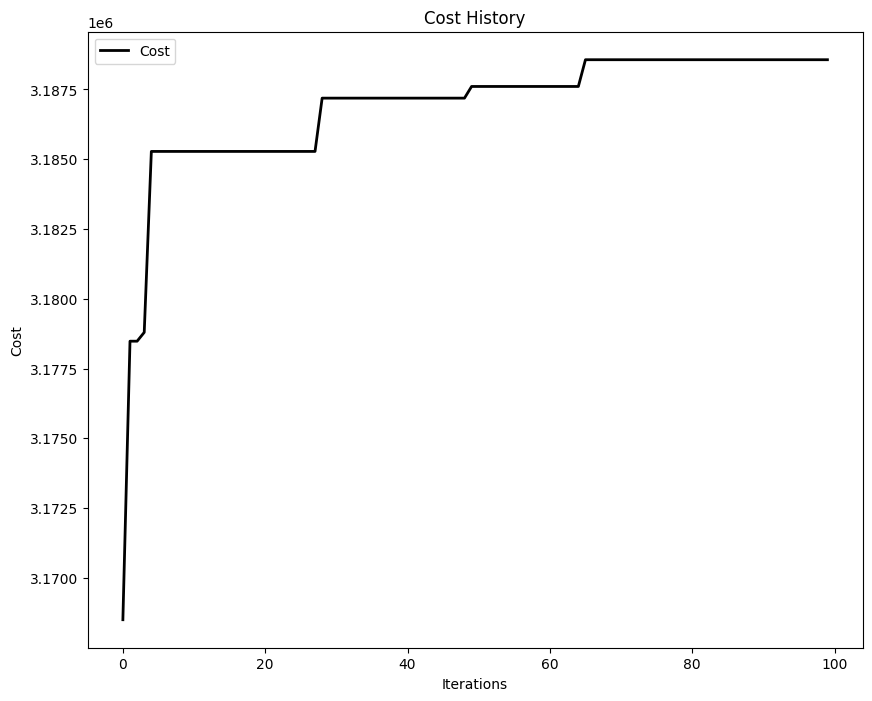

In [11]:
resultPSO.SaveResult(result)

#### if PSO optimization has already being run and we have some inititial input wehights

Read initial position input weights 

In [17]:
import math 
decisionVariableArray = constraint_file['variable_splits']
n_particles =  int(10+2*math.sqrt(len(decisionVariableArray)))
n_particles

24

In [18]:
pso_date = '05.21.2024' #datetime.date.today().strftime("%m.%d.%Y")# 
fileName = base_path + f'Pos Result {pso_date}.csv' 
pos_df = pd.read_csv(fileName, index_col = 0)# read the pso result file to get the input weights
inputWeights = np.tile(pos_df.pos.to_numpy(), [n_particles, 1]) # create the input weights parameters
inputWeights

array([[1.02594094, 1.06668707, 1.19909446, ..., 0.92462159, 0.75350217,
        1.05600449],
       [1.02594094, 1.06668707, 1.19909446, ..., 0.92462159, 0.75350217,
        1.05600449],
       [1.02594094, 1.06668707, 1.19909446, ..., 0.92462159, 0.75350217,
        1.05600449],
       ...,
       [1.02594094, 1.06668707, 1.19909446, ..., 0.92462159, 0.75350217,
        1.05600449],
       [1.02594094, 1.06668707, 1.19909446, ..., 0.92462159, 0.75350217,
        1.05600449],
       [1.02594094, 1.06668707, 1.19909446, ..., 0.92462159, 0.75350217,
        1.05600449]])

run_pso method of SavantPSO class function, with PSO hyper parameters and input weights as initial position

In [ ]:
itNum = 50
result = resultPSO.run_pso(options, n_particles=n_particles, itNum = itNum , init_pos=inputWeights)


2024-05-21 14:18:27,772 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/Input Weight History 05.21.2024.csv


pyswarms.single.global_best:   0%|          |0/50

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3188565.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3188565.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3188565.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3188565.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned

pyswarms.single.global_best:   2%|▏         |1/50, best_cost=-3.19e+6

yhat: -3188565.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168638.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176250.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165665.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:   4%|▍         |2/50, best_cost=-3.19e+6

yhat: -3176176.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169779.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3171361.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169253.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3167757.0
client_budget - analytical_spend_latest_peri

pyswarms.single.global_best:   6%|▌         |3/50, best_cost=-3.19e+6

yhat: -3175903.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166174.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169526.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165355.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3164876.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:   8%|▊         |4/50, best_cost=-3.19e+6

yhat: -3166431.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169612.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169636.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3164644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170872.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  10%|█         |5/50, best_cost=-3.19e+6

yhat: -3176337.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172539.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168017.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165233.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3165418.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=-3.19e+6

yhat: -3175772.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172516.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3174823.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168175.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3162523.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=-3.19e+6

yhat: -3174120.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3161288.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3161437.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3163175.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3164871.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  16%|█▌        |8/50, best_cost=-3.19e+6

yhat: -3173213.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166887.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165777.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166474.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3175474.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  18%|█▊        |9/50, best_cost=-3.19e+6

yhat: -3166840.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3168375.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3159647.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3163788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3174798.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  20%|██        |10/50, best_cost=-3.19e+6

yhat: -3161088.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3163250.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165460.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3164928.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169796.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  22%|██▏       |11/50, best_cost=-3.19e+6

yhat: -3182550.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168351.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173950.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168651.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169955.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  24%|██▍       |12/50, best_cost=-3.19e+6

yhat: -3165076.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3159870.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3161116.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170904.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165660.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  26%|██▌       |13/50, best_cost=-3.19e+6

yhat: -3165824.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3174814.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175081.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168520.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3180946.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  28%|██▊       |14/50, best_cost=-3.19e+6

yhat: -3164409.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3176038.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3163659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174023.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3175967.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=-3.19e+6

yhat: -3163837.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169121.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174573.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174298.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3181554.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=-3.19e+6

yhat: -3168813.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3162474.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3167822.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178482.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3171760.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  56%|█████▌    |28/50, best_cost=-3.19e+6

yhat: -3165145.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3162330.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168827.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3181323.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169747.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  58%|█████▊    |29/50, best_cost=-3.19e+6

yhat: -3181425.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167251.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3171013.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170479.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176145.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  70%|███████   |35/50, best_cost=-3.19e+6

yhat: -3175361.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175965.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175661.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3165171.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3178217.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  72%|███████▏  |36/50, best_cost=-3.19e+6

yhat: -3169735.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170668.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166200.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172082.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171766.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  74%|███████▍  |37/50, best_cost=-3.19e+6

yhat: -3171025.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171706.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3171682.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175188.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171873.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  76%|███████▌  |38/50, best_cost=-3.19e+6

yhat: -3170857.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177678.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176215.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173204.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3182089.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  78%|███████▊  |39/50, best_cost=-3.19e+6

yhat: -3176403.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3165834.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172021.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175669.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170617.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  80%|████████  |40/50, best_cost=-3.19e+6

yhat: -3170267.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3169662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169990.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169868.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174435.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  84%|████████▍ |42/50, best_cost=-3.19e+6

yhat: -3171000.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3163474.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3172554.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3169863.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3176788.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  86%|████████▌ |43/50, best_cost=-3.19e+6

yhat: -3176190.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3175319.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3180636.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173321.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3175674.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  88%|████████▊ |44/50, best_cost=-3.19e+6

yhat: -3171264.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170019.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3165128.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3177806.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3170785.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  90%|█████████ |45/50, best_cost=-3.19e+6

yhat: -3168519.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167281.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171191.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166990.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171188.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best:  92%|█████████▏|46/50, best_cost=-3.19e+6

yhat: -3174422.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3163382.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3174406.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3176965.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3178679.0
client_budget - analytical_spend_latest_perio

pyswarms.single.global_best:  94%|█████████▍|47/50, best_cost=-3.19e+6

yhat: -3177786.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3177533.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3160737.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168688.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3166750.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  96%|█████████▌|48/50, best_cost=-3.19e+6

yhat: -3179825.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3167788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175033.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173904.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  -0.0
yhat: -3172753.0
client_budget - analytical_spend_latest_period

pyswarms.single.global_best:  98%|█████████▊|49/50, best_cost=-3.19e+6

yhat: -3161523.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3175749.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3171027.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3168613.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
yhat: -3173366.0
client_budget - analytical_spend_latest_period:

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-3.19e+6
2024-05-21 23:00:17,851 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -3188565.0, best pos: [1.02594094 1.06668707 1.19909446 1.17410375 0.93574561 0.99352703
 1.15714177 0.75529575 1.0750722  0.93069391 1.07702314 1.0292041
 0.98972824 1.05564513 1.04671947 1.07639673 0.72814563 1.0732615
 0.99199985 0.98062088 0.16138924 0.16358608 0.27784042 0.1461271
 0.33855867 0.75958581 0.35518489 0.9481788  0.86775767 0.96191126
 0.83793167 0.87166832 0.9861992  0.88857025 0.73219883 0.86454372
 1.04614964 0.91330532 1.04106604 1.08274089 0.95951064 0.94103071
 0.98140799 0.75828477 0.94388041 0.88627567 1.05266431 1.07256771
 0.95018488 0.99879493 0.90117559 0.92462159 0.75350217 1.05600449]


yhat: -3169630.0
client_budget - analytical_spend_latest_period: 0
Compute duration: 31310.0833632946


if needed cave the PSO optimization results and plot the cost through the different iterations 

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/Pos Result 05.21.2024.csv
File exists. Please delete it first.
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/Iteration History 05.21.2024.csv
File exists. Please delete it first.


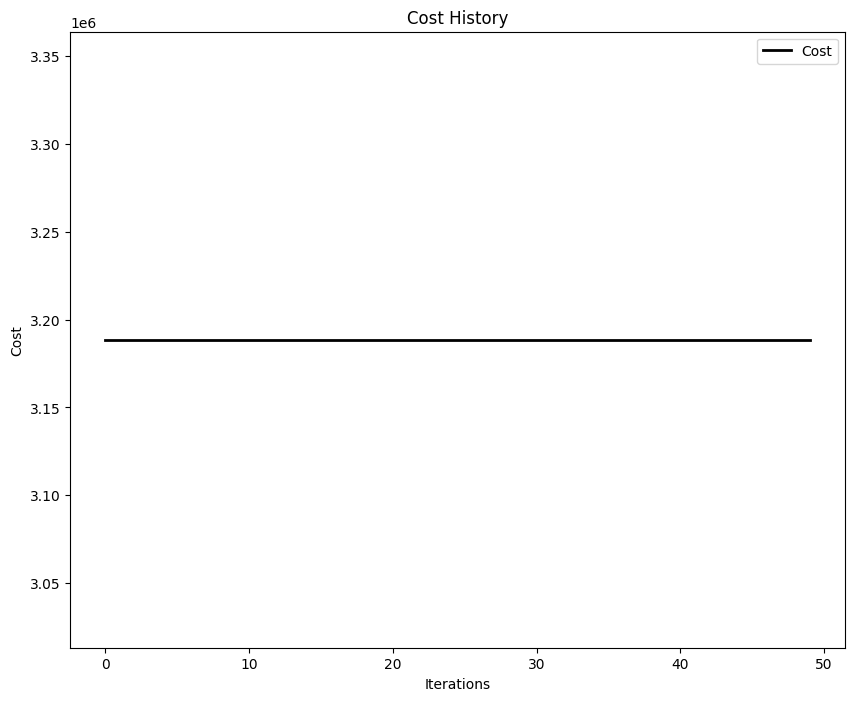

In [ ]:
resultPSO.SaveResult(result)